The bound we seek to minimize is a lower bound on the wasserstein distance from its true barycenter 



$
\min_{a \in \Delta}   W(a,\sum_k \frac{b_{jk}}{N} )     \\
\begin{align}
= \min_{a \in \Delta, \pi \geq 0}  & \sum_i \sum_j  d_{ij} \pi_{ij}  \\
            & \sum_{j}\pi_{ij} = a_i , \forall i \\
            & \sum_{i} \pi_{ij} = \sum_{k=1}^N  \frac{b_{jk}}{N} , \forall j \\
= \min_{a \in \Delta} \max_{ \alpha, \beta }  & \sum_i \sum_k \alpha_i  \frac{a_i}{N} + \sum_j \sum_k  \beta_j  \frac{b_{jk}}{N} \\
            & \alpha_i + \beta_j \leq d_{ij}, \forall (i,j)    \\
\end{align}  
$
 
$
\begin{align}
\leq \min_{a \in \Delta} \sum_{k=1}^N   \frac{1}{N}   \max_{ \alpha, \beta }  & \sum_i   \alpha_i  a_i + \sum_j    \beta_j b_{jk}\\
            & \alpha_i + \beta_j \leq d_{ij}, \forall (i,j)   
\end{align}  
$

$
= \min_{a \in \Delta} \sum_{k=1}^N \frac{1}{N} W(a,  b_{jk}  )
$

where the distribution minimizing the last line is the true barycenter and $d_{ij} = ||x_i -x_j||_2$

The problem and the bound are trivial since the first opt problem has opt solution 0. This is useless

!! Error in here!!

Assuming that each of the $k=1,\cdots,N$ marginals has up to $j=1,\cdots,n$ atoms (so we can represent the support with a $n$ dimensional vector) and each atom has probability $b_{jk}$, then using  $||x_i-x_j||_2 = ||x_i||- 2 x_i^{\top}x_j + ||x_j||$,
the multi marginal formulation of Agueh impemented in ot.lp.barycenter seems to be:

$
\begin{align}
= \max_{a \in \Delta, \pi \geq 0}  &  \sum_{k=1}^{N-1} \sum_{l=k+1}^{N}    \sum_{i=1}\sum_{j=i} \frac{1}{N^2} x_i x_j\pi_{ijkl}  \\
            & \sum_{j}\pi_{ijk} = a_i , \forall i \\
            & \sum_{i} \pi_{ijk} =   b_{jk} , \forall j, k 
\end{align}  
$
 

# Libs

In [1]:
import numpy as np

from ortools.linear_solver import pywraplp
from collections import defaultdict
import ot

import scipy as sp
import scipy.sparse as sps

import cvxopt
from cvxopt import solvers, matrix, spmatrix

import cvxpy as cp


import matplotlib.pyplot as plt

import sys

sys.path.append("/home/charles/Projects/BarycentersAgePyramid/Python")

import pickle


from WassAge import *

from pathlib import Path

# Params

In [2]:
n_distributions = 4
n = 3

weights = np.ones(n_distributions) / n_distributions

# Benchmark on the solution returned by ot module

In [3]:
M=sp.spatial.distance_matrix(np.arange(n).reshape(-1,1), np.arange(n).reshape(-1,1))**2 #make it square otherwise the triangle ineq is tight
M

array([[0., 1., 4.],
       [1., 0., 1.],
       [4., 1., 0.]])

In [4]:
   A=np.matrix( 
        [[ 1/6,2/3,1/6],
        [1/2,0,1/2],
         [1/3,1/3,1/3],
        [0,1/2,1/2]] ).T

In [5]:


if n_distributions==2:
    #2 distribution, 1 has 3 atoms the other only 2
    A=np.matrix( 
        [[ 1/6,2/3,1/6],
      [1/2,0,1/2]] ).T
    
elif n_distributions==4:
       A=np.matrix( 
        [[ 1/6,2/3,1/6],
        [1/2,0,1/2],
         [1/3,1/3,1/3],
        [0,1/2,1/2]] ).T
        
else:
    raise Exception("Fatal error - need 2 or 4 distributions")
    
A=np.asarray(A)

A, A.shape

(array([[0.16666667, 0.5       , 0.33333333, 0.        ],
        [0.66666667, 0.        , 0.33333333, 0.5       ],
        [0.16666667, 0.5       , 0.33333333, 0.5       ]]), (3, 4))

In [6]:
    if weights is None:
        weights = np.ones(A.shape[1]) / A.shape[1]
    else:
        assert(len(weights) == A.shape[1])

    n_distributions = A.shape[1]
    n = A.shape[0]

    n2 = n * n
    c = np.zeros((0))
    b_eq1 = np.zeros((0))
    for i in range(n_distributions):
        c = np.concatenate((c, M.ravel() * weights[i]))
        b_eq1 = np.concatenate((b_eq1, A[:, i]))
    c = np.concatenate((c, np.zeros(n)))

    lst_idiag1 = [sps.kron(sps.eye(n), np.ones((1, n))) for i in range(n_distributions)]
    #  row constraints
    A_eq1 = sps.hstack((sps.block_diag(lst_idiag1), sps.coo_matrix((n_distributions * n, n))))

    # columns constraints
    lst_idiag2 = []
    lst_eye = []
    for i in range(n_distributions):
        if i == 0:
            lst_idiag2.append(sps.kron(np.ones((1, n)), sps.eye(n)))
            lst_eye.append(-sps.eye(n))
        else:
            lst_idiag2.append(sps.kron(np.ones((1, n)), sps.eye(n - 1, n)))
            lst_eye.append(-sps.eye(n - 1, n))

    A_eq2 = sps.hstack((sps.block_diag(lst_idiag2), sps.vstack(lst_eye)))
    b_eq2 = np.zeros((A_eq2.shape[0]))

    # full problem
    A_eq = sps.vstack((A_eq1, A_eq2))
    b_eq = np.concatenate((b_eq1, b_eq2))

    

In [7]:
np.set_printoptions(edgeitems=30)
import sys
np.core.arrayprint._line_width = 300
np.core.arrayprint._line_height = 300
np.set_printoptions(threshold=np.inf)
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:200% !important; }</style>"))

arr=np.asarray( A_eq.todense() )
def getSpace(i):
    if i < 0:
        return ""
    return " "

for i in range(arr.shape[0]):
    print(" ".join([ f"{getSpace(i)}{i}" for i in arr[i,:]]))

        

 1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0 

In [8]:
for i in range(b_eq.shape[0]):
    print( b_eq[i] )

0.16666666666666666
0.6666666666666666
0.16666666666666666
0.5
0.0
0.5
0.3333333333333333
0.3333333333333333
0.3333333333333333
0.0
0.5
0.5
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


In [9]:
c

array([0.  , 0.25, 1.  , 0.25, 0.  , 0.25, 1.  , 0.25, 0.  , 0.  , 0.25,
       1.  , 0.25, 0.  , 0.25, 1.  , 0.25, 0.  , 0.  , 0.25, 1.  , 0.25,
       0.  , 0.25, 1.  , 0.25, 0.  , 0.  , 0.25, 1.  , 0.25, 0.  , 0.25,
       1.  , 0.25, 0.  , 0.  , 0.  , 0.  ])

In [10]:
A_eq.shape

(21, 39)

In [11]:

    solver = None
    if solver is None:
        solver = 'interior-point'

        options = {'sparse': True, 'disp': True}
        sol = sp.optimize.linprog(c, A_eq=A_eq, b_eq=b_eq, method=solver,
                                  options=options)
        x = sol.x
        b = x[-n:]

    else:

        h = np.zeros((n_distributions * n2 + n))
        G = -sps.eye(n_distributions * n2 + n)

        sol = solvers.lp(matrix(c), scipy_sparse_to_spmatrix(G), matrix(h),
                         A=scipy_sparse_to_spmatrix(A_eq), b=matrix(b_eq),
                         solver=solver)

        x = np.array(sol['x'])
        b = x[-n:].ravel()


Primal Feasibility  Dual Feasibility    Duality Gap         Step             Path Parameter      Objective          
1.0                 1.0                 1.0                 -                1.0                 12.0                
0.3584817288813     0.3584817288813     0.3584817288813     0.6492589718232  0.3584817288813     2.855360039156      
0.07241264849557    0.07241264849557    0.07241264849557    0.8098207215392  0.07241264849557    0.6534669076637     
0.01561813117217    0.01561813117217    0.01561813117217    0.7871536729688  0.01561813117217    0.3525936119227     
0.0005018274071567  0.0005018274071569  0.0005018274071568  0.9713824454985  0.0005018274071568  0.2941800129255     
3.144314397311e-08  3.144314393612e-08  3.144314398595e-08  0.9999378160755  3.144314397668e-08  0.2916668191009     
1.572139765092e-12  1.572140098119e-12  1.57216120464e-12   0.9999499999043  1.572169898567e-12  0.2916666666743     
Optimization terminated successfully.
         Current fu

In [12]:
x[-3:]

array([0.25891567, 0.34386801, 0.39721632])

In [13]:
ot.lp.barycenter(A,M)

array([0.25891567, 0.34386801, 0.39721632])

$
\min_{a \in \Delta}   W(a,\sum_k \frac{b_{jk}}{N} )     \\
\begin{align}
= \min_{a \in \Delta, \pi \geq 0}  & \sum_i \sum_j d_{ij} \pi_{ij}  \\
            & \sum_{j}\pi_{ij} = a_i , \forall i \\
            & \sum_{i} \pi_{ij} = \sum_{k=1}^N  \frac{b_{jk}}{N} , \forall j 
\end{align}  
$

In [14]:
AAvg = A.mean(axis=1)
AAvg

array([0.25 , 0.375, 0.375])

In [15]:
# Compare against manual minimization of wass barycenter wrt euclidean average of dist
# The lp solved here should have smaller value than the value fo the barycenter computed above with ot.lp.barycenter

In [16]:
# This problem is trivial with solution pi_ij = 1 if i =1 j and sum_j pi_ij = pi_i = a_i forall i. => a_j = \sum_k b_jk/N forall j

def wassBarycenterFixedDist(OneDDist):

    #1
    # Solver
    solver = pywraplp.Solver('WassEuclBarycenter', pywraplp.Solver.GLOP_LINEAR_PROGRAMMING)


    #2
    # Dual vars associated to  sum_i pî_ij = b_j and sum_j pî_ij = a_i
    dictVarPi={}
    dictVarA={}

    #pi_ij : flow variables
    for i in range(M.shape[0]):
        dictVarA[i] = solver.NumVar(0, solver.infinity(), f'a_{i}')  #>=0
        for j in range(M.shape[1]):
            dictVarPi[i,j] =   solver.NumVar(0, solver.infinity(), f'pi_{i}{j}')  #>=0


    #3
    #Constraints alpha_i + beta_j \leq M_ij 
    dictConstraintsA={}
    for i in range(M.shape[0]):
        dictConstraintsA[i] = solver.Constraint(0, 0)
        dictConstraintsA[i].SetCoefficient( dictVarA[i] , -1 )
        for j in range(M.shape[1]):
            dictConstraintsA[i].SetCoefficient( dictVarPi[i,j] ,1 )

    dictConstraintsB={}    
    for j in range(M.shape[1]):
        dictConstraintsB[j] = solver.Constraint( OneDDist[j], OneDDist[j])
        for i in range(M.shape[0]):
            dictConstraintsB[j].SetCoefficient( dictVarPi[i,j] ,1 )

    #Simplex constraints for a
    dictConstraintsA= solver.Constraint(1, 1)
    for i in range(M.shape[0]):
        dictConstraintsA.SetCoefficient( dictVarA[i], 1)
        
        
    #4
    #Objective function
    objective = solver.Objective()
    objective.SetMinimization()    #dual is maximization problem 
    for i in range(M.shape[0]):
        for j in range(M.shape[1]):
             objective.SetCoefficient(dictVarPi[i,j], M[ i , j])

    #Solve
    solver.Solve()
    
    #Get the cost
    cost=0
    for i in range(M.shape[0]):
        for j in range(M.shape[1]):
            cost += dictVarPi[i,j].solution_value() * M[i,j] 
    
    dictVarPiSol={}
    dictVarPiSol = { (i,j):  dictVarPi[i,j].solution_value() for (i,j) in dictVarPi.keys() }
    dictVarASol = {  i: dictVarA[i].solution_value() for i in dictVarA.keys() }
    
    return dictVarPiSol,  dictVarASol , cost
        

In [17]:
#Need 0 cost and trivial solution is just the single average measure AAvg
dictVarPi, dictVarA, cost = wassBarycenterFixedDist( AAvg)
cost

0.0

In [18]:
dictVarPi

{(0, 0): 0.25,
 (0, 1): 0.0,
 (0, 2): 0.0,
 (1, 0): 0.0,
 (1, 1): 0.375,
 (1, 2): 0.0,
 (2, 0): 0.0,
 (2, 1): 0.0,
 (2, 2): 0.375}

In [19]:
list(dictVarA.values()), AAvg

([0.25, 0.375, 0.375], array([0.25 , 0.375, 0.375]))

### Util for solver return code

In [20]:
def getCode(code, solver):
    if code == solver.OPTIMAL :
        return "OPTIMAL"
    elif code == solver.FEASIBLE:
        return "FEASIBLE"
    elif  code == solver.INFEASIBLE:
        return "INFEASIBLE"
    elif  code == solver.UNBOUNDED:
        return "UNBOUNDED"
    elif  code == solver.ABNORMAL:
        return "ABNORMAL"
    elif  code == solver.MODEL_INVALID:
        return "MODEL_INVALID"
    elif  code == solver. NOT_SOLVED:
        return "NOT_SOLVED"
    else:
        return "NA code"

In [51]:
a=np.ones((2,3))
b=np.ones((2,6))

a.shape 

(2, 3)

### For reference, here is the primal flow problem

In [53]:

def wassDistanceFixedDistPrimal(a,b,M):

    if a.shape != b.shape:
        raise exception ("Fatal error! a and b matrices do not have the same dimension!")
        
    if a.shape[0] != M.shape[0]:
         raise exception ("Fatal error! distributions do not have the same number of atoms as the ground distance matrix!")
    
    #1
    # Solver
    solver = pywraplp.Solver('WassDistPrimal', pywraplp.Solver.GLOP_LINEAR_PROGRAMMING)


    #2
    # Dual vars associated to  sum_i pî_ij = b_j and sum_j pî_ij = a_i
    dictVarPi={}

    #pi_ij : flow variables
    for i in range(M.shape[0]):
        for j in range(M.shape[1]):
            dictVarPi[i,j] =   solver.NumVar(0, solver.infinity(), f'pi_{i}{j}')  #>=0


    #3
    #Constraints sum_i pi_ij = M_j 
    dictConstraintsA={}
    for j in range(M.shape[0]):
        dictConstraintsA[j] = solver.Constraint(a[j], a[j])
        for i in range(M.shape[1]):
            dictConstraintsA[j].SetCoefficient( dictVarPi[i,j] ,1 )

    #Constraints sum_j pi_ij = M_j 
    dictConstraintsB={}    
    for i in range(M.shape[1]):
        dictConstraintsB[i] = solver.Constraint( b[i], b[i])
        for j in range(M.shape[0]):
            dictConstraintsB[i].SetCoefficient( dictVarPi[i,j] ,1 )
        
        
    #4
    #Objective function
    objective = solver.Objective()
    objective.SetMinimization()     #primal: min assignment
    for i in range(M.shape[0]):
        for j in range(M.shape[1]):
             objective.SetCoefficient(dictVarPi[i,j], M[ i , j])

    #Solve
    solveCode=solver.Solve()    
    strCode=getCode(solveCode,solver)
    
    if solveCode != 0:
        print(f"Fatal error, could not solve the primal! - {strCode}")
        print(a)
        print(b)
        return {i: 0 for i in range(M.shape[0])}, 0
    
    #Get the cost
    cost=0
    for i in range(M.shape[0]):
        for j in range(M.shape[1]):
            cost += dictVarPi[i,j].solution_value() * M[i,j] 
    
    dictVarPiSol={}
    dictVarPiSol = { (i,j):  dictVarPi[i,j].solution_value() for (i,j) in dictVarPi.keys() }

    
    return dictVarPiSol, cost

### The dual problem

In [22]:
def wassDistanceFixedDistDual(a,b,M):
    
    #1
    # Solver
    solver = pywraplp.Solver('DualTransportion', pywraplp.Solver.GLOP_LINEAR_PROGRAMMING)


    #2
    # Dual vars associated to  sum_i pî_ij = b_j and sum_j pî_ij = a_i
    dictVarAlpha={}
    dictVarBeta={}

    #pi_ij : flow variables
    for i in range(M.shape[0]):
        dictVarBeta[i] =   solver.NumVar(-solver.infinity(), solver.infinity(), f'beta_{i}')  #urs continuous variable 

    for j in range(M.shape[1]):
        dictVarAlpha[j] =   solver.NumVar(-solver.infinity(), solver.infinity(), f'alpha_{j}')  #urs continuous variable 



    #3
    #Constraints alpha_i + beta_j \leq M_ij 
    dictConstraints={}
    for i in range(M.shape[1]):
        for j in range(M.shape[0]):
            dictConstraints[i,j] = solver.Constraint(-solver.infinity(), M[i,j])
            dictConstraints[i,j].SetCoefficient( dictVarAlpha[j] ,1 )
            dictConstraints[i,j].SetCoefficient( dictVarBeta[i] ,1 )

    #4
    #Objective function
    objective = solver.Objective() 
    objective.SetMaximization()                                    #dual is *maximization* problem 
    
    for i in range(M.shape[0]):
         objective.SetCoefficient(dictVarBeta[i], b[i])

    for j in range(M.shape[1]):
         objective.SetCoefficient(dictVarAlpha[j], a[j])
        
    #5 Solve
    solveCode=solver.Solve()    
    strCode=getCode(solveCode,solver)
    print(f"Solve code is:{solveCode}")
        
    if solveCode != 0:
        print(f"Fatal error, could not solve the dual! - returning 0 gradient - {strCode}")
        print(a)
        print(b)
        return {i: 0 for i in range(M.shape[1])}, 0
        
    #6 Get the solution 
    cost = 0 
    for i in range(M.shape[0]):
        cost += dictVarBeta[i].solution_value() * b[i] 
    for j in range(M.shape[1]):
        cost += dictVarAlpha[j].solution_value() * a[j] 
            
    return {i : dictVarAlpha[i].solution_value() for i in dictVarAlpha.keys()}, cost

# Try to implement a simple projected gradient algorithm

## The gradient is the dual optimal alpha variables corresponding to the a distribution atoms 

In [23]:
wassDistanceFixedDistDual(list(dictVarA.values()), AAvg ,M)

Solve code is:0


({0: 0.0, 1: -1.0, 2: 0.0}, 0.0)

In [24]:
wassDistanceFixedDistDual(np.ones(3)/3, AAvg ,M)

Solve code is:0


({0: 2.0, 1: 1.0, 2: 0.0}, 0.12499999999999994)

In [25]:
def projectOntoSimplex(x):
    
    """
    Projection: point that minimizes distance to convex set (simpelx) using norm 2
    99.9% sure there exists a relatively complex analytic solution for the problem, but solving the problem is probably less bug-prone
    """
    n= len(x)
    u=cp.Variable(n)
    normLoss=cp.norm2( x - u  ) 
    
      
    constList=[]
    constList.append( cp.sum(u) == 1)
    constList.append(u >= 0)
        
    probl=cp.Problem( cp.Minimize( normLoss ),
                     constraints=constList)
    
    probl.solve()
    
    return u.value

In [26]:
initPoint=[0,2]
sol=projectOntoSimplex(initPoint)
sol

array([-2.66572857e-11,  1.00000000e+00])

(0, 2)

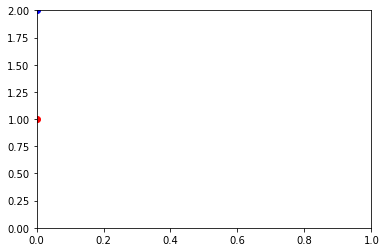

In [27]:
#Visuzalize the projection onto the simplex
plt.plot( [initPoint[0]], [initPoint[1]], "bo")
plt.plot( [sol[0]], [sol[1]], "ro")
plt.xlim([0,1])
plt.ylim([0,2])

In [28]:
A[:,0]

array([0.16666667, 0.66666667, 0.16666667])

## Now the entire algo

In [29]:

def projectedGradientDescent(ainit, A, M, stepSize=10**-3, maxIter=50):
    
    numDist=A.shape[1]
    aold=ainit
    anew=ainit
    print(f"Considering {numDist} distributions")
    
    #Iterate until convergence or fixed number of iterations
    for iter in range(maxIter):
        
        #compute the gradient as the average of all dual opt solutions to the N wass distances
        grad=np.zeros_like(ainit)
        for i in range(numDist):
            gradDict, _ =wassDistanceFixedDistDual(aold,A[:,i],M)
            print(np.array(list(gradDict.values())))
            grad += np.array(list(gradDict.values()))/numDist

        if np.sum( grad**2 )**0.5 < 10**-5:
            print("breaking out, the gradient is too close to zero")
            print(grad)
            break
            
        anewTentative= aold- grad *stepSize
        anew=projectOntoSimplex(anewTentative)
        
        if np.sum( (anew-aold)**2 )**0.5 < 10**-5:
            print("breaking out, the iterates are too close to one another")
            break
        aold=anew
        
    return anew

In [30]:
def computeAvgWassDist(a, A,M):
    
    numDist=A.shape[1]
    wassDist=0
    
    for i in range(A.shape[1]):
        _, dist = wassDistanceFixedDistDual(a,A[:,i],M)
        wassDist += dist/numDist
        
    return wassDist

### Start with uniform distribution

In [31]:
ainit=np.ones_like(A[:,0])/len(A[:,0])
ainit

array([0.33333333, 0.33333333, 0.33333333])

In [32]:
solProjGradient = projectedGradientDescent(ainit, A ,M)
solProjGradient

Considering 4 distributions
Solve code is:0
[ 0. -1.  0.]
Solve code is:0
[0. 1. 0.]
Solve code is:0
[ 0. -1.  0.]
Solve code is:0
[2. 1. 0.]
Solve code is:0
[ 0. -1.  0.]
Solve code is:0
[0. 1. 0.]
Solve code is:0
[-2. -1.  0.]
Solve code is:0
[2. 1. 0.]
breaking out, the gradient is too close to zero
[0. 0. 0.]


array([0.33299998, 0.33350001, 0.33350001])

In [33]:
computeAvgWassDist(solProjGradient,A,M )

Solve code is:0
Solve code is:0
Solve code is:0
Solve code is:0


0.2916666666666667

### Start with the solution found by ot.lp.barycenter

In [34]:
solProjGradientWarmStart = projectedGradientDescent(x[-3:], A ,M)
solProjGradientWarmStart, x[-3:]

Considering 4 distributions
Solve code is:0
[ 0. -1.  0.]
Solve code is:0
[0. 1. 0.]
Solve code is:0
[-2. -1.  0.]
Solve code is:0
[2. 1. 0.]
breaking out, the gradient is too close to zero
[0. 0. 0.]


(array([0.25891567, 0.34386801, 0.39721632]),
 array([0.25891567, 0.34386801, 0.39721632]))

In [35]:
#as we see from above, the 4 gradients cancel out to 0 when we take the average => hence overall gradient is really 0
#dualOpt, cost =wassDistanceFixedDistDual(solProjGradientWarmStart, A [:,0],M )
#dualOpt, cost

In [36]:
computeAvgWassDist(solProjGradientWarmStart,A ,M )

Solve code is:0
Solve code is:0
Solve code is:0
Solve code is:0


0.2916666666666667

# Test it out on real data

## DA shp

In [37]:
dfGeoClean = normalizeCleanDfGeo( readDAShp(city="Quebec City") )
dfGeoClean.head(2)

Reading neibourhoods from Quebec City


ShapeAr Type  Dwllngs  Hoshlds    GeoUID  Popultn CD_UID  CSD_UID  \
0  0.03739   DA      390      367  24230282      578   2423  2423027   
1  0.17787   DA      364      361  24230583      584   2423  2423027   

       CT_UID CMA_UID  ...     80_84     85_89  90_94  95_99  100_+    ID  \
0  4210011.00   24421  ...  0.035714  0.008929    0.0    0.0    0.0  31.0   
1  4210113.01   24421  ...  0.071429  0.053571    0.0    0.0    0.0  18.0   

                    NOM     SUPERFI  PERIMET  \
0         Saint-Sauveur  3974715.39  14978.5   
1  Pointe-de-Sainte-Foy  4251524.43  12888.9   

                                            geometry  
0  POLYGON ((-208624.8003297645 316568.9436800948...  
1  POLYGON ((-214807.2264055035 311855.7902562238...  

[2 rows x 38 columns]

In [38]:
dfGeoClean[LIST_AGE_COLS].sum(axis=1)

0      1.0
1      1.0
2      1.0
3      1.0
4      1.0
      ... 
878    1.0
879    1.0
880    1.0
881    1.0
882    1.0
Length: 879, dtype: float64

In [39]:
dfGeoCleanAge = dfGeoClean[LIST_AGE_COLS]

In [40]:
subsetRows=min( 50, dfGeoClean.shape[0])

# Dist matrix

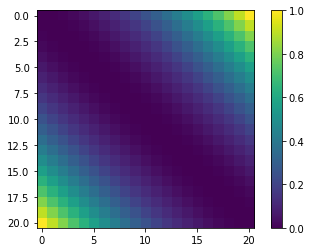

In [41]:
distMatrix = getDistanceAgeCohorts()
f=plt.figure()
plt.imshow(distMatrix)
plt.colorbar()
 

### Make sure the data is really normalized by DA

In [42]:
dfSubsetRenormalized=dfGeoClean[LIST_AGE_COLS].div(   dfGeoClean[ LIST_AGE_COLS ].sum(axis=1), axis=0)  

In [43]:
dfSubsetRenormalized.sum(axis=1).describe()

count    8.790000e+02
mean     1.000000e+00
std      1.056444e-16
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      1.000000e+00
dtype: float64

In [44]:
ainit= np.ones( subsetRows )/subsetRows
ainit

array([0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02,
       0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02,
       0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02,
       0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02,
       0.02, 0.02, 0.02, 0.02, 0.02, 0.02])

In [45]:
projectedGradientDescent( ainit,
                         A=dfSubsetRenormalized.T.values, 
                         M=distMatrix )

Considering 879 distributions
Solve code is:3
Fatal error, could not solve the dual! - returning 0 gradient - UNBOUNDED
[0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02
 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02
 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02
 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02]
[0.03571429 0.01785714 0.03571429 0.02678571 0.08928571 0.15178571
 0.11607143 0.10714286 0.03571429 0.0625     0.0625     0.05357143
 0.0625     0.04464286 0.02678571 0.02678571 0.03571429 0.00892857
 0.         0.         0.        ]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


ValueError: operands could not be broadcast together with shapes (50,) (21,) (50,) 

In [ ]:
dfGeoClean[LIST_AGE_COLS][:subsetRows].T

In [ ]:
A=dfSubsetRenormalized.T.values
A[:,0].sum()
ainit

In [54]:
wassDistanceFixedDistPrimal(A[:,0],ainit,distMatrix)

NameError: name 'exception' is not defined

In [47]:
%debug

> <ipython-input-21-e32f0a30ab3e>(22)wassDistanceFixedDistPrimal()
     20     dictConstraintsA={}
     21     for j in range(M.shape[0]):
---> 22         dictConstraintsA[j] = solver.Constraint(a[j], a[j])
     23         for i in range(M.shape[1]):
     24             dictConstraintsA[j].SetCoefficient( dictVarPi[i,j] ,1 )



ipdb>  a


a = array([0.16666667, 0.66666667, 0.16666667])
b = array([0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02,
       0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02,
       0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02,
       0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02,
       0.02, 0.02, 0.02, 0.02, 0.02, 0.02])
M = array([[0.    , 0.0025, 0.01  , 0.0225, 0.04  , 0.0625, 0.09  , 0.1225,
        0.16  , 0.2025, 0.25  , 0.3025, 0.36  , 0.4225, 0.49  , 0.5625,
        0.64  , 0.7225, 0.81  , 0.9025, 1.    ],
       [0.0025, 0.    , 0.0025, 0.01  , 0.0225, 0.04  , 0.0625, 0.09  ,
        0.1225, 0.16  , 0.2025, 0.25  , 0.3025, 0.36  , 0.4225, 0.49  ,
        0.5625, 0.64  , 0.7225, 0.81  , 0.9025],
       [0.01  , 0.0025, 0.    , 0.0025, 0.01  , 0.0225, 0.04  , 0.0625,
        0.09  , 0.1225, 0.16  , 0.2025, 0.25  , 0.3025, 0.36  , 0.4225,
        0.49  , 0.5625, 0.64  , 0.7225, 0.81  ],
       [0.0225, 0.01  , 0.002

ipdb>  a.shape


a = array([0.16666667, 0.66666667, 0.16666667])
b = array([0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02,
       0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02,
       0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02,
       0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02,
       0.02, 0.02, 0.02, 0.02, 0.02, 0.02])
M = array([[0.    , 0.0025, 0.01  , 0.0225, 0.04  , 0.0625, 0.09  , 0.1225,
        0.16  , 0.2025, 0.25  , 0.3025, 0.36  , 0.4225, 0.49  , 0.5625,
        0.64  , 0.7225, 0.81  , 0.9025, 1.    ],
       [0.0025, 0.    , 0.0025, 0.01  , 0.0225, 0.04  , 0.0625, 0.09  ,
        0.1225, 0.16  , 0.2025, 0.25  , 0.3025, 0.36  , 0.4225, 0.49  ,
        0.5625, 0.64  , 0.7225, 0.81  , 0.9025],
       [0.01  , 0.0025, 0.    , 0.0025, 0.01  , 0.0225, 0.04  , 0.0625,
        0.09  , 0.1225, 0.16  , 0.2025, 0.25  , 0.3025, 0.36  , 0.4225,
        0.49  , 0.5625, 0.64  , 0.7225, 0.81  ],
       [0.0225, 0.01  , 0.002

ipdb>  a.shape


a = array([0.16666667, 0.66666667, 0.16666667])
b = array([0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02,
       0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02,
       0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02,
       0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02,
       0.02, 0.02, 0.02, 0.02, 0.02, 0.02])
M = array([[0.    , 0.0025, 0.01  , 0.0225, 0.04  , 0.0625, 0.09  , 0.1225,
        0.16  , 0.2025, 0.25  , 0.3025, 0.36  , 0.4225, 0.49  , 0.5625,
        0.64  , 0.7225, 0.81  , 0.9025, 1.    ],
       [0.0025, 0.    , 0.0025, 0.01  , 0.0225, 0.04  , 0.0625, 0.09  ,
        0.1225, 0.16  , 0.2025, 0.25  , 0.3025, 0.36  , 0.4225, 0.49  ,
        0.5625, 0.64  , 0.7225, 0.81  , 0.9025],
       [0.01  , 0.0025, 0.    , 0.0025, 0.01  , 0.0225, 0.04  , 0.0625,
        0.09  , 0.1225, 0.16  , 0.2025, 0.25  , 0.3025, 0.36  , 0.4225,
        0.49  , 0.5625, 0.64  , 0.7225, 0.81  ],
       [0.0225, 0.01  , 0.002

ipdb>  a.shape


a = array([0.16666667, 0.66666667, 0.16666667])
b = array([0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02,
       0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02,
       0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02,
       0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02,
       0.02, 0.02, 0.02, 0.02, 0.02, 0.02])
M = array([[0.    , 0.0025, 0.01  , 0.0225, 0.04  , 0.0625, 0.09  , 0.1225,
        0.16  , 0.2025, 0.25  , 0.3025, 0.36  , 0.4225, 0.49  , 0.5625,
        0.64  , 0.7225, 0.81  , 0.9025, 1.    ],
       [0.0025, 0.    , 0.0025, 0.01  , 0.0225, 0.04  , 0.0625, 0.09  ,
        0.1225, 0.16  , 0.2025, 0.25  , 0.3025, 0.36  , 0.4225, 0.49  ,
        0.5625, 0.64  , 0.7225, 0.81  , 0.9025],
       [0.01  , 0.0025, 0.    , 0.0025, 0.01  , 0.0225, 0.04  , 0.0625,
        0.09  , 0.1225, 0.16  , 0.2025, 0.25  , 0.3025, 0.36  , 0.4225,
        0.49  , 0.5625, 0.64  , 0.7225, 0.81  ],
       [0.0225, 0.01  , 0.002

ipdb>  a


a = array([0.16666667, 0.66666667, 0.16666667])
b = array([0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02,
       0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02,
       0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02,
       0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02,
       0.02, 0.02, 0.02, 0.02, 0.02, 0.02])
M = array([[0.    , 0.0025, 0.01  , 0.0225, 0.04  , 0.0625, 0.09  , 0.1225,
        0.16  , 0.2025, 0.25  , 0.3025, 0.36  , 0.4225, 0.49  , 0.5625,
        0.64  , 0.7225, 0.81  , 0.9025, 1.    ],
       [0.0025, 0.    , 0.0025, 0.01  , 0.0225, 0.04  , 0.0625, 0.09  ,
        0.1225, 0.16  , 0.2025, 0.25  , 0.3025, 0.36  , 0.4225, 0.49  ,
        0.5625, 0.64  , 0.7225, 0.81  , 0.9025],
       [0.01  , 0.0025, 0.    , 0.0025, 0.01  , 0.0225, 0.04  , 0.0625,
        0.09  , 0.1225, 0.16  , 0.2025, 0.25  , 0.3025, 0.36  , 0.4225,
        0.49  , 0.5625, 0.64  , 0.7225, 0.81  ],
       [0.0225, 0.01  , 0.002

ipdb>  a


a = array([0.16666667, 0.66666667, 0.16666667])
b = array([0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02,
       0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02,
       0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02,
       0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02,
       0.02, 0.02, 0.02, 0.02, 0.02, 0.02])
M = array([[0.    , 0.0025, 0.01  , 0.0225, 0.04  , 0.0625, 0.09  , 0.1225,
        0.16  , 0.2025, 0.25  , 0.3025, 0.36  , 0.4225, 0.49  , 0.5625,
        0.64  , 0.7225, 0.81  , 0.9025, 1.    ],
       [0.0025, 0.    , 0.0025, 0.01  , 0.0225, 0.04  , 0.0625, 0.09  ,
        0.1225, 0.16  , 0.2025, 0.25  , 0.3025, 0.36  , 0.4225, 0.49  ,
        0.5625, 0.64  , 0.7225, 0.81  , 0.9025],
       [0.01  , 0.0025, 0.    , 0.0025, 0.01  , 0.0225, 0.04  , 0.0625,
        0.09  , 0.1225, 0.16  , 0.2025, 0.25  , 0.3025, 0.36  , 0.4225,
        0.49  , 0.5625, 0.64  , 0.7225, 0.81  ],
       [0.0225, 0.01  , 0.002

ipdb>  b.shape


*** The specified object '.shape' is not a function or was not found along sys.path.


ipdb>  b
ipdb>  b.shape


*** The specified object '.shape' is not a function or was not found along sys.path.


ipdb>  exit


In [ ]:
A[:,0].sum()

In [57]:
np.array([0.1,0.6,0.7])

array([0.1, 0.6, 0.7])